Code repurposed from Kaggle [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-cryptocurrencies]

## import dependencies

In [1]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

from yahoo_fin.stock_info import get_data

%matplotlib inline

## load and inspect data

In [2]:
crypto_currency = 'USDC'
against_currency = 'USD'

start = dt.datetime(2014,1,1)
end = dt.datetime.now()

base_df = get_data(f'{crypto_currency}-{against_currency}', start, end, index_as_date = True, interval = '1d')
base_df

,open,high,low,close,adjclose,volume,ticker
2018-10-07,1.004100,1.007680,1.001900,1.002210,1.002210,3.829000e+05,USDC-USD
2018-10-08,1.004270,1.008330,1.000030,1.006860,1.006860,1.088030e+05,USDC-USD
2018-10-09,1.004940,1.019080,1.003970,1.009620,1.009620,7.117830e+05,USDC-USD
2018-10-10,1.009940,1.031230,1.001730,1.009780,1.009780,4.177290e+06,USDC-USD
2018-10-11,1.008610,1.018710,1.001140,1.012720,1.012720,1.322240e+06,USDC-USD
...,...,...,...,...,...,...,...
2021-07-03,0.999956,1.000187,0.998901,0.999500,0.999500,1.578667e+09,USDC-USD
2021-07-04,0.999566,1.000839,0.999459,1.000528,1.000528,1.887496e+09,USDC-USD
2021-07-05,1.000501,1.000731,0.999662,1.000059,1.000059,2.312602e+09,USDC-USD
2021-07-06,1.000126,1.000599,0.999552,1.000370,1.000370,1.998621e+09,USDC-USD


In [3]:
base_df['spread'] = base_df.high - base_df.low
base_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1005 entries, 2018-10-07 to 2021-07-08
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      943 non-null    float64
 1   high      943 non-null    float64
 2   low       943 non-null    float64
 3   close     943 non-null    float64
 4   adjclose  943 non-null    float64
 5   volume    943 non-null    float64
 6   ticker    1005 non-null   object 
 7   spread    943 non-null    float64
dtypes: float64(7), object(1)
memory usage: 70.7+ KB


## Plot the closing value of USDCoin over time

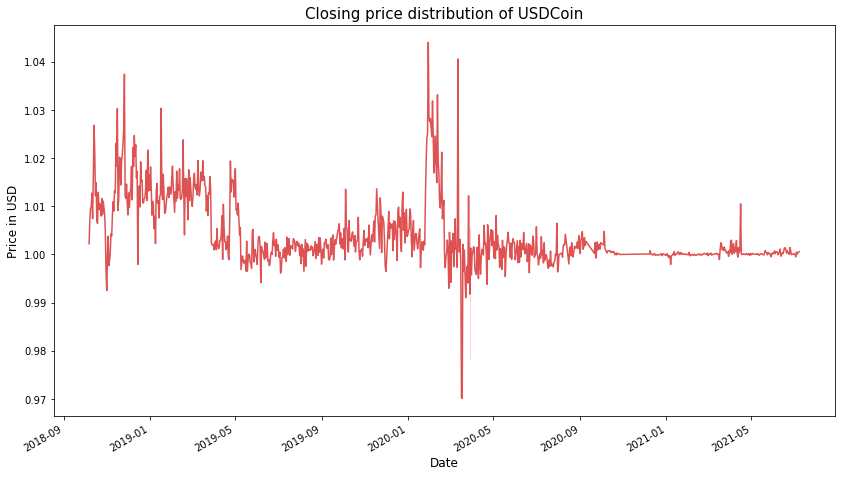

In [4]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.close.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Closing price distribution of USDCoin", fontsize=15)
plt.show()

Text(0.5, 1.0, 'Daily price spread of USDCoin')

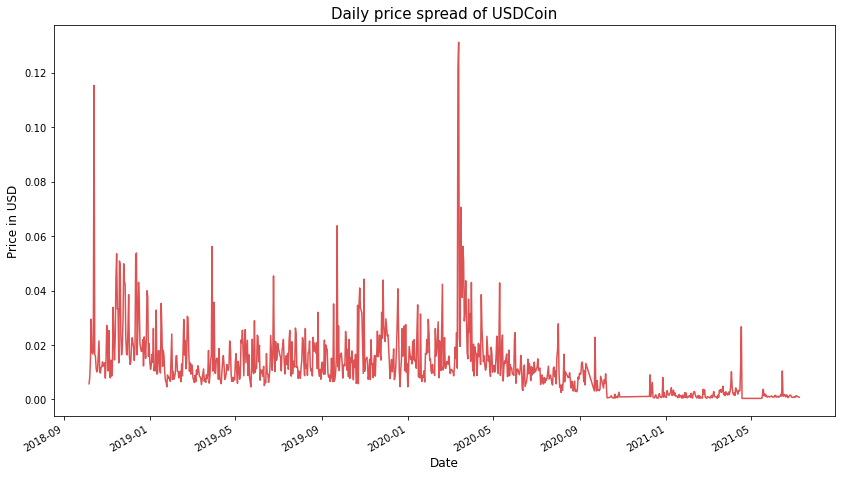

In [5]:
fig, ax = plt.subplots(figsize=(14,8))

sns.lineplot(y = base_df.spread.values, x=base_df.index.values, alpha=0.8, color=color[3])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.autofmt_xdate()
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price in USD', fontsize=12)
plt.title("Daily price spread of USDCoin", fontsize=15)

## Candlestick chart

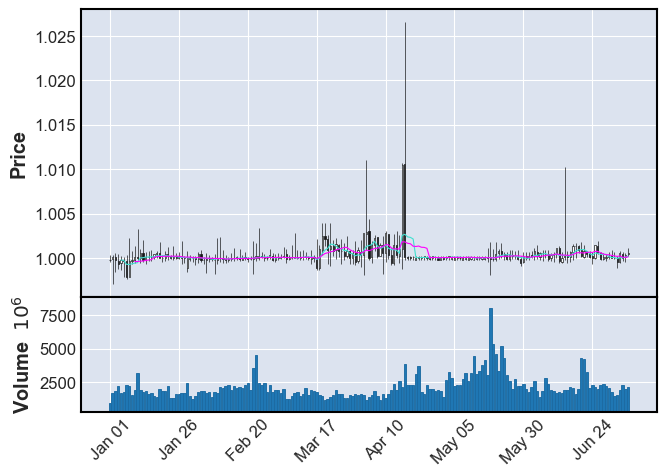

In [11]:
import matplotlib.ticker as mticker
import mplfinance as mpf

temp_base_df = base_df.copy(deep=False)

temp_base_df = temp_base_df.drop(['spread'], axis=1)
mpf.plot(temp_base_df.loc['2021-1-1':], type='candle', mav=(5,10), volume=True)

## Future Price Prediction

In [7]:
from fbprophet import Prophet

In [8]:
price_predict_df = base_df['close'].copy(deep=False).reset_index()
price_predict_df.columns = ["ds", "y"]
#price_predict_df = price_predict_df[price_predict_df['ds']>'2020-6-1']
price_predict_df

,ds,y
0,2018-10-07,1.002210
1,2018-10-08,1.006860
2,2018-10-09,1.009620
3,2018-10-10,1.009780
4,2018-10-11,1.012720
...,...,...
1000,2021-07-03,0.999500
1001,2021-07-04,1.000528
1002,2021-07-05,1.000059
1003,2021-07-06,1.000370


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1027,2021-08-03,1.000129,0.993352,1.006505
1028,2021-08-04,1.000343,0.993705,1.006510
1029,2021-08-05,1.001468,0.994336,1.007805
1030,2021-08-06,1.000029,0.992582,1.006639
1031,2021-08-07,1.000185,0.992932,1.006657


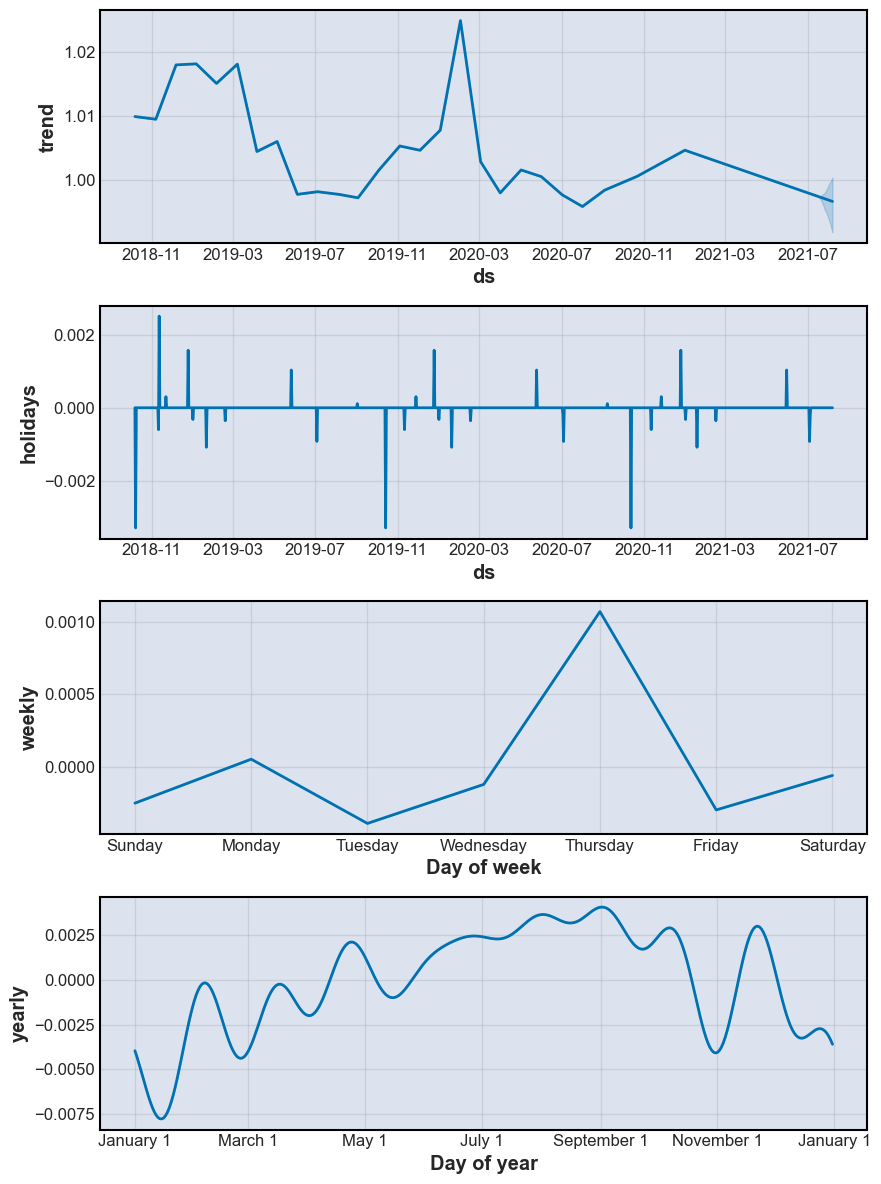

In [9]:
m = Prophet(changepoint_prior_scale=.7)
m.add_country_holidays(country_name='US')
#m.add_country_holidays(country_name='CN')
m.fit(price_predict_df);
m.train_holiday_names

future = m.make_future_dataframe(periods=30)

forecast = m.predict(future)
fig = m.plot_components(forecast)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

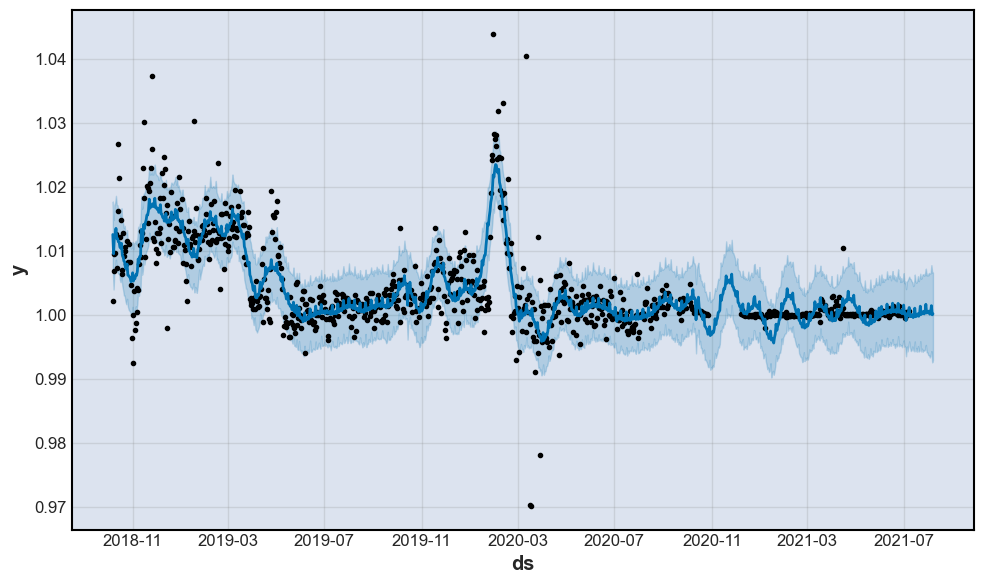

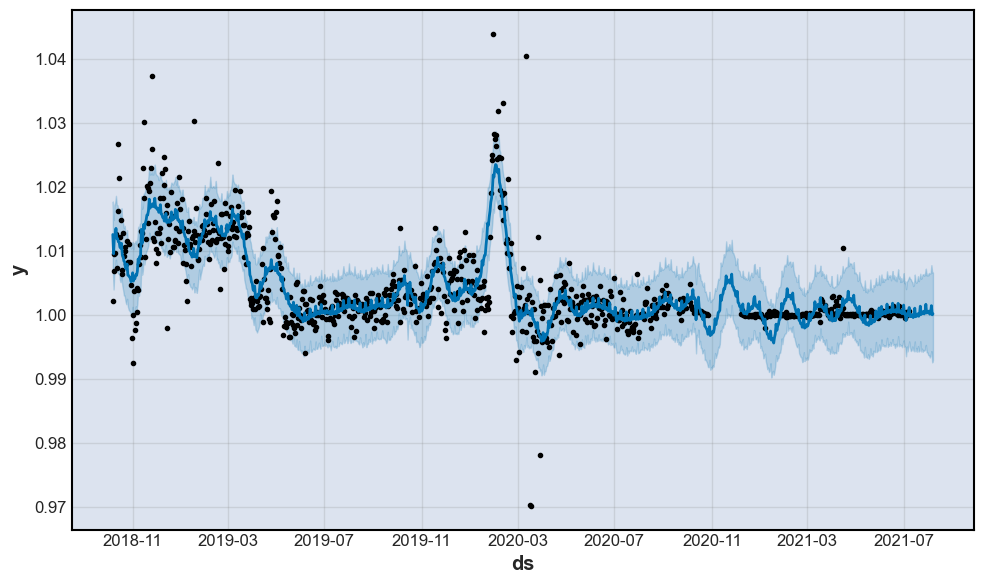

In [10]:
m.plot(forecast)